### Import python libraries

In [1]:
!pip install mysql-connector-python

In [2]:
import pandas as pd
import matplotlib.pyplot as plyt
import seaborn as sns

In [8]:
import mysql.connector

con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

### Load SQL queries

In [9]:
imdb_title_crew_df = pd.read_sql_query("""
SELECT * 
FROM movies.imdb_title_crew;
""",con)

In [10]:
imdb_title = pd.read_sql_query("""
SELECT * 
FROM movies.imdb_title_basics;
""",con)

In [11]:
imdb_people = pd.read_sql_query("""
SELECT * 
FROM movies.imdb_name_basics;
""",con)

In [12]:
imdb_ratings = pd.read_sql_query("""
SELECT 
	tconst,
    averagerating,
    numvotes
FROM movies.imdb_title_ratings
""",con)

## Analysis

First of all, we combine SQL tables and manipulate the data so that we have all relevant information in seperate columns of one table. Relevant information includes movie title, movie rating, director names.

In [20]:
# One column per each director identifier
imdb_test = imdb_title_crew_df['directors'].str.split(pat=',',expand=True)

In [21]:
imdb_test.iloc[ : ,1].isna().sum() 
# Out of 146144 movies, 130417 have only 1 director 

130417

In [23]:
# Add movie identifier to table
imdb_test['tconst'] = imdb_title_crew_df['tconst']

In [24]:
# Drop irrelevant columns
imdb_test = imdb_test.drop(imdb_test.iloc[:,3:26], axis = 1)

In [25]:
# Rename table columns
imdb_title_crew_df['dir1'] = imdb_test[0]
imdb_title_crew_df['dir2'] = imdb_test[1]
imdb_title_crew_df['dir3'] = imdb_test[2]

In [33]:
# Rename table to something shorter
imdb_crew = imdb_title_crew_df

In [34]:
# One column per each writer identifier
writers = imdb_title_crew_df['writers'].str.split(pat=',',expand=True)

In [35]:
writers.iloc[:,3].isna().sum() 
# Out of 146144 movies, 140714 have only max 3 writers 

140714

In [36]:
# Rename table columns
imdb_crew['wri1'] = writers[0]
imdb_crew['wri2'] = writers[1]
imdb_crew['wri3'] = writers[2]

In [38]:
# Add director and writer names to the table
imdb = imdb_title.set_index('tconst').join(imdb_crew.set_index('tconst'))

In [40]:
nconst_to_names = imdb_people.loc[:, ['nconst','primary_name']]

In [41]:
imdb = imdb.join(nconst_to_names.set_index('nconst'),
          on='dir1',
          rsuffix='_names')

In [42]:
imdb = imdb.rename(columns={'primary_name':'dir1_name'})

In [43]:
imdb = imdb.join(nconst_to_names.set_index('nconst'),
          on='dir2',
          rsuffix='_names')

In [44]:
imdb = imdb.rename(columns={'primary_name':'dir2_name'})

In [45]:
imdb = imdb.join(nconst_to_names.set_index('nconst'),
          on='dir3',
          rsuffix='_names')

In [46]:
imdb = imdb.rename(columns={'primary_name':'dir3_name'})

In [47]:
imdb = imdb.join(nconst_to_names.set_index('nconst'),
          on='wri1',
          rsuffix='_names')

In [48]:
imdb = imdb.rename(columns={'primary_name':'wri1_name'})

In [49]:
imdb = imdb.join(nconst_to_names.set_index('nconst'),
          on='wri2',
          rsuffix='_names')

In [50]:
imdb = imdb.rename(columns={'primary_name':'wri2_name'})

In [51]:
imdb = imdb.join(nconst_to_names.set_index('nconst'),
          on='wri3',
          rsuffix='_names')

In [52]:
imdb = imdb.rename(columns={'primary_name':'wri3_name'})

In [54]:
imdb = imdb.reset_index()

In [55]:
# Add ratings to the table
imdb = imdb.join(imdb_ratings.set_index('tconst'),
          on='tconst',
          rsuffix='_ratings')

In [57]:
# One genre per column 
imdb[['genre1','genre2','genre3']] = imdb['genres'].str.split(pat=',',expand=True)

In [91]:
imdb['genre3'].isna().sum()

116708

In [77]:
imdb.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,directors,writers,dir1,dir2,...,dir2_name,dir3_name,wri1_name,wri2_name,wri3_name,averagerating,numvotes,genre1,genre2,genre3
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",nm0712540,"nm0023551,nm1194313,nm0347899,nm1391276",nm0712540,None,...,NaN,NaN,Abrar Alvi,Mahasweta Devi,Gulzar,7.0,77.0,Action,Crime,Drama
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",nm0002411,None,nm0002411,None,...,NaN,NaN,NaN,NaN,NaN,7.2,43.0,Biography,Drama,None
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,nm0000080,"nm0000080,nm0462648",nm0000080,None,...,NaN,NaN,Orson Welles,Oja Kodar,NaN,6.9,4517.0,Drama,None,None
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",nm0611531,nm0347899,nm0611531,None,...,NaN,NaN,Gulzar,NaN,NaN,6.1,13.0,Comedy,Drama,None
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy","nm0765384,nm0749914","nm1360635,nm0749914",nm0765384,nm0749914,...,Raoul Ruiz,NaN,Pía Rey,Raoul Ruiz,NaN,6.5,119.0,Comedy,Drama,Fantasy


#### Chart 1: Directors with most movies with ratings above 7.5 (median is 6.1 with 1.35 std) since 2010 with at least 100 votes

In [69]:
chart1data1 = imdb.sort_values(by='averagerating',ascending = False).loc[(imdb['averagerating'].notna()) & (imdb['numvotes']>100)]

In [72]:
chart1data2 = chart1data1.sort_values(by='averagerating',ascending = False).loc[imdb['averagerating'] > 7.5]

In [73]:
chart1data3 = chart1data2.groupby('dir1_name').count().sort_values(by='tconst',ascending = False)

In [74]:
chart1data4 = chart1data3.loc[chart1data3['tconst'] > 3]['tconst']

In [75]:
chart1data4

dir1_name
Paul Dugdale           6
Kaushik Ganguly        5
Denis Villeneuve       5
Alex Gibney            4
Keitarô Motonaga       4
Tim Van Someren        4
Anurag Singh           4
Shunsuke Tada          4
Shoojit Sircar         4
Christopher Nolan      4
Anthony Russo          4
Quentin Tarantino      4
Ram Gopal Varma        4
Aris Chatzistefanou    4
Martin Scorsese        4
Name: tconst, dtype: int64

Text(0.5, 1.0, 'Movies With 7.5+ Ratings')

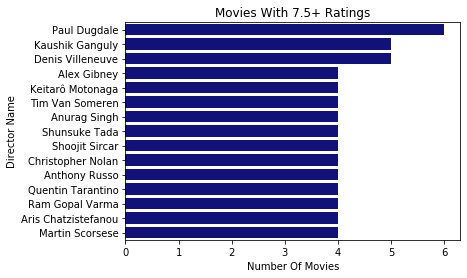

In [76]:
chart1index = list(chart1data4.index)
chart1values = list(chart1data4)
chart1 = sns.barplot(x=chart1values, 
                     y=chart1index,
                     color='darkblue')
chart1.set(ylabel='Director Name', xlabel='Number Of Movies')
chart1.set_title('Movies With 7.5+ Ratings')

### Top 3 rated genres (only movies with at least 100 votes, at least 50 movies that year) by year

In [171]:
chart2data1 = imdb[['genre1','averagerating','start_year','numvotes']].loc[imdb['genre1'].notna()]

In [172]:
chart2data1 = chart2data1.rename(columns={'genre1':'genre'})

In [173]:
chart2data2 = imdb[['genre2','averagerating','start_year','numvotes']].loc[imdb['genre2'].notna()]

In [174]:
chart2data2 = chart2data2.rename(columns={'genre2':'genre'})

In [175]:
chart2data3 = imdb[['genre3','averagerating','start_year','numvotes']].loc[imdb['genre3'].notna()]

In [176]:
chart2data3 = chart2data3.rename(columns={'genre3':'genre'})

In [177]:
chart2data4 = pd.concat([chart2data1, chart2data2, chart2data3])

In [182]:
chart2data5 = chart2data4[['genre','averagerating','start_year','numvotes']].loc[chart2data4['averagerating'].notna()]

In [184]:
chart2data6 = chart2data5.loc[chart2data5['numvotes']>100]

In [199]:
chart2data7 = chart2data6.groupby(['start_year','genre']).count()

In [231]:
chart2data8 = chart2data6.groupby(['start_year','genre']).median()

In [233]:
chart2data9 = chart2data8.join(chart2data7,
                 rsuffix='_count')

In [234]:
chart2data9

averagerating  numvotes  averagerating_count  \
start_year genre                                                     
2010                           6.30     104.0                    1   
           Action              5.90     961.0                  385   
           Adventure           6.10    1393.5                  152   
           Animation           6.70     632.0                   77   
           Biography           7.00     972.0                  121   
...                             ...       ...                  ...   
2019       Sci-Fi              6.30    3589.0                   24   
           Sport               6.30     318.5                   12   
           Thriller            5.90     336.5                  110   
           War                 6.45     668.5                   12   
           Western             5.70    1034.0                    3   

                      numvotes_count  
start_year genre                      
2010                               1  
           Action                385  
           Adventure             152  
           Animation              77  
           Biography             121  
...                              ...  
2019       Sci-Fi                 24  
           Sport                  12  
           Thriller              110  
           War                    12  
           Western                 3  

[228 rows x 4 columns]

In [235]:
chart2data10 = chart2data9.loc[chart2data9['averagerating_count'] > 50]

In [239]:
chart2data10.groupby(["start_year"])["averagerating"].nlargest(3)     

start_year  start_year  genre      
2010        2010        Documentary    7.30
                        Biography      7.00
                        Music          6.95
2011        2011        Documentary    7.30
                        Biography      6.90
                        Music          6.90
2012        2012        Documentary    7.20
                        Biography      7.10
                        Music          7.00
2013        2013        Documentary    7.10
                        Music          7.05
                        Biography      7.00
2014        2014        Documentary    7.20
                        Biography      7.00
                        Sport          7.00
2015        2015        Documentary    7.20
                        Biography      7.10
                        History        6.95
2016        2016        Documentary    7.10
                        Biography      6.95
                        History        6.80
2017        2017        Documentary    7

### Chart 3: Genres of Top 100 Movies By Rating 

In [263]:
#chart2data6 = one row per genre, movies with at least 100 numvotes and no 'averagerating' N/A, since 2010
chart3data1 = chart2data6.sort_values('averagerating', ascending=False)

In [274]:
chart3data1 = chart3data1.loc[chart3data1['averagerating'] > 8]

In [275]:
chart3data1 = chart3data1.groupby('genre').count()['averagerating'].nlargest(10)

Text(0.5, 1.0, 'Movies With 8.0+ Ratings')

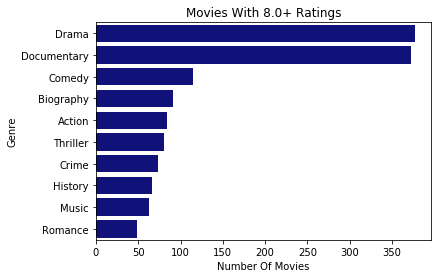

In [277]:
chart3ylabel = list(chart3data1.index)
chart3values = list(chart3data1)
chart3 = sns.barplot(x=chart3values, 
                     y=chart3ylabel,
                     color='darkblue')
chart3.set(ylabel='Genre', xlabel='Number Of Movies')
chart3.set_title('Movies With 8.0+ Ratings')

### Chart 4: Movie Rating Mean, Median, Volatility

In [281]:
#chart2data6 = one row per genre, movies with at least 100 numvotes and no 'averagerating' N/A, since 2010

In [348]:
chart4data1 = chart2data6.groupby('genre').describe()

In [349]:
chart4data1.drop(chart4data1.columns[8:],axis=1,inplace=True)

In [355]:
chart4data2 = chart4data1.loc[chart4data1['averagerating', 'count'] > 250]

In [374]:
chart4data2 = chart4data2.sort_values(by=('averagerating', '50%'),ascending=False)

In [377]:
chart4data2.head(10).index

Index(['Documentary', 'Biography', 'Music', 'Sport', 'History', 'War',
       'Animation', 'Drama', 'Crime', 'Family'],
      dtype='object', name='genre')

In [379]:
# Manually select the top 10 Median genres
Top10Median = list(chart4data2.head(10).index)

In [392]:
chart5data1 = chart2data6.loc[chart2data6['genre'].isin(Top10Median)]

In [396]:
chart5data2 = chart5data1[['genre','averagerating']]

In [397]:
chart5data2

,genre,averagerating
2,Drama,6.9
10,Drama,6.8
13,Drama,6.9
15,Animation,7.8
21,Crime,6.7
...,...,...
143874,War,6.8
143996,Sport,6.6
144600,War,1.3
145433,Drama,7.8


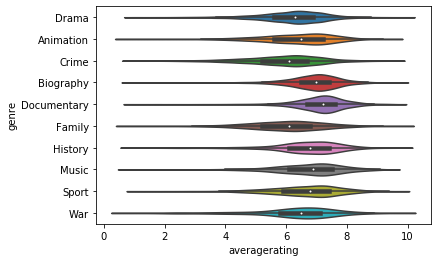

In [398]:
ax = sns.violinplot(x="averagerating", y="genre", data=chart5data2)

In [5]:
imdb_principles = pd.read_sql_query("""
SELECT * 
FROM movies.imdb_title_principals
LIMIT 1000;
""",con)

In [6]:
imdb_principles.columns

Index(['tconst', 'ordering', 'nconst', 'category', 'job', 'characters'], dtype='object')

In [7]:
imdb_principles.head(30)

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,,"[""The Man""]"
1,tt0111414,2,nm0398271,director,,
2,tt0111414,3,nm3739909,producer,producer,
3,tt0323808,10,nm0059247,editor,,
4,tt0323808,1,nm3579312,actress,,"[""Beth Boothby""]"
5,tt0323808,2,nm2694680,actor,,"[""Steve Thomson""]"
6,tt0323808,3,nm0574615,actor,,"[""Sir Lachlan Morrison""]"
7,tt0323808,4,nm0502652,actress,,"[""Lady Delia Morrison""]"
8,tt0323808,5,nm0362736,director,,
9,tt0323808,6,nm0811056,producer,producer,


In [148]:
imdb_principles.pivot_table(index=imdb_principles['tconst'],columns='category')

ordering                                                     \
category     actor   actress archive_footage cinematographer composer   
tconst                                                                  
tt0111414      1.0       NaN             NaN             NaN      NaN   
tt0323808      2.5  2.500000             NaN             9.0      8.0   
tt0417610      2.0  3.000000             NaN             NaN     10.0   
tt0469152      3.5  1.500000             NaN             9.0      8.0   
tt0473032      1.5       NaN             NaN             NaN      NaN   
...            ...       ...             ...             ...      ...   
tt1294688      3.0  2.000000             NaN             9.0      8.0   
tt1298644      3.5  1.500000             NaN             NaN      NaN   
tt1300159      3.0  2.000000             NaN             NaN      NaN   
tt1308748      2.0  2.666667             NaN             7.0      6.0   
tt1308754      2.0  2.000000             NaN             NaN      NaN   

                                                                    
category  director editor producer production_designer self writer  
tconst                                                              
tt0111414      2.0    NaN      3.0                 NaN  NaN    NaN  
tt0323808      5.0   10.0      6.5                 NaN  NaN    NaN  
tt0417610      5.0    NaN      8.0                 NaN  NaN    6.0  
tt0469152      5.0   10.0      7.0                 NaN  NaN    6.0  
tt0473032      3.0    NaN      NaN                 NaN  NaN    NaN  
...            ...    ...      ...                 ...  ...    ...  
tt1294688      5.0   10.0      6.5                 NaN  NaN    NaN  
tt1298644      5.0    NaN     10.0                 NaN  NaN    7.5  
tt1300159      5.0    NaN     10.0                 NaN  NaN    7.5  
tt1308748      5.0    NaN      NaN                 NaN  NaN    NaN  
tt1308754      NaN    NaN      NaN                10.0  NaN    NaN  

[142 rows x 11 columns]